In [9]:
import pandas as pd

# 设置全局字体为微软雅黑，以支持中文显示
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.unicode.east_asian_width', True)

# 读取数据集
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'
links_path = 'links.csv'

# 加载数据集到DataFrame
ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)
links_df = pd.read_csv(links_path)

# 显示数据集的前几行以了解其结构
display_data = {
    'Ratings': ratings_df.head(),
    'Movies': movies_df.head(),
    'Tags': tags_df.head(),
    'Links': links_df.head()
}

display_data


{'Ratings':    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
 'Movies':    movieId                               title                                       genres
 0        1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
 1        2                      Jumanji (1995)                   Adventure|Children|Fantasy
 2        3             Grumpier Old Men (1995)                               Comedy|Romance
 3        4            Waiting to Exhale (1995)                         Comedy|Drama|Romance
 4        5  Father of the Bride Part II (1995)                                       Comedy,
 'Tags':    userId  movieId              tag   timestamp
 0       2    60756            funny  1445714994
 1       2    60756  Highly quotable  1445714996
 2       2    60756     will f

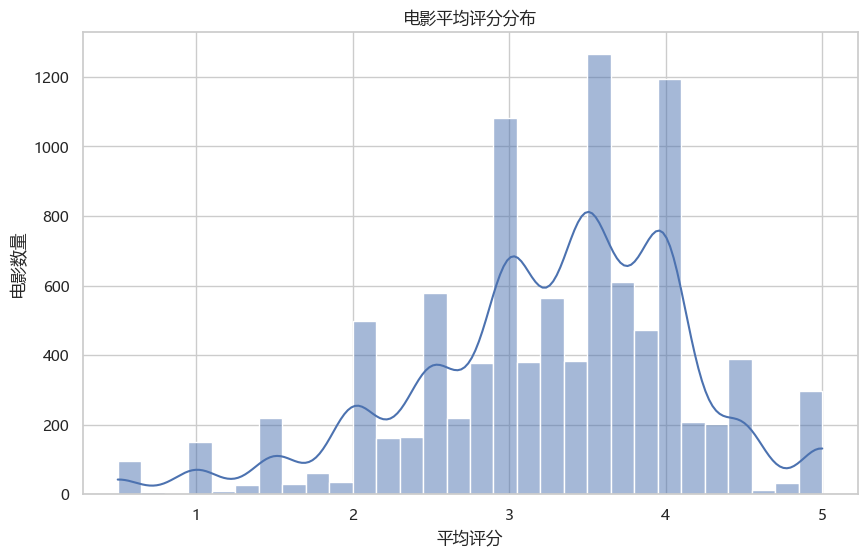

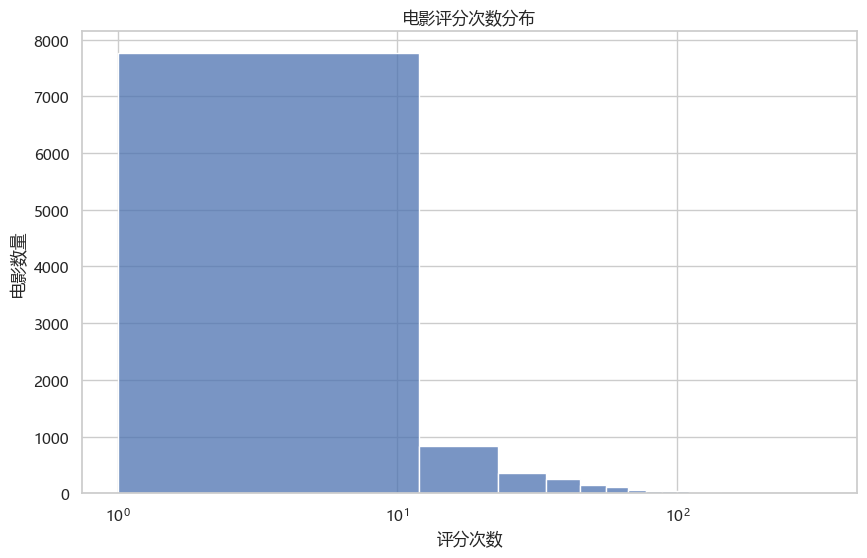

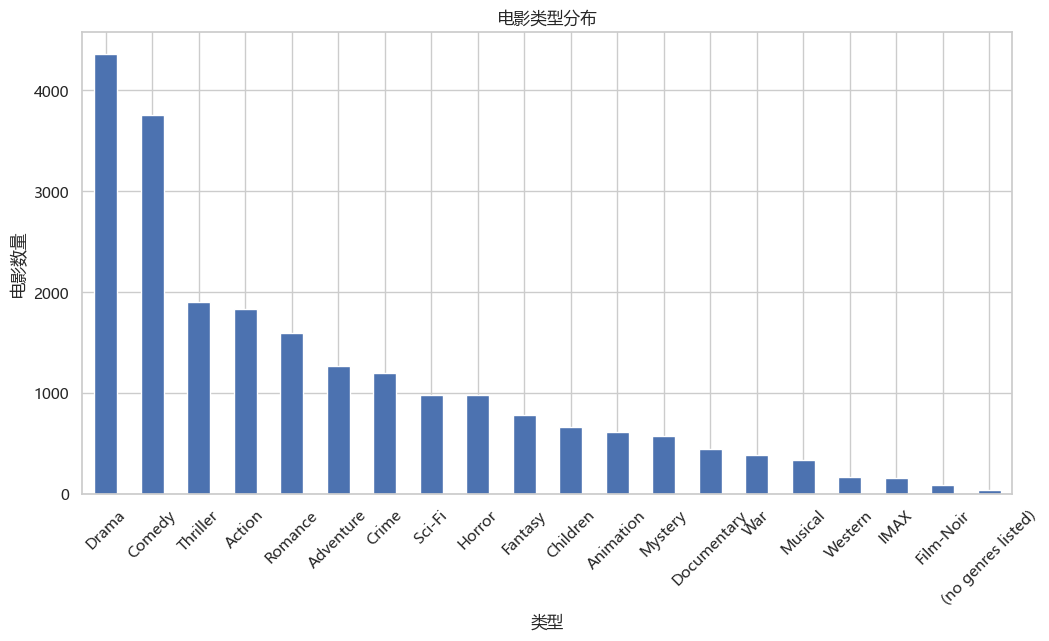

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格和字体，以便于显示中文
sns.set(style="whitegrid", font='Microsoft YaHei')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建一个包含电影评分平均值和评分次数的DataFrame
movie_ratings = ratings_df.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_ratings.columns = movie_ratings.columns.droplevel(0)
movie_ratings.columns = ['average_rating', 'number_of_ratings']

# 合并电影信息和评分信息
movie_data_merged = pd.merge(movies_df, movie_ratings, on='movieId')

# 查看电影平均评分分布
plt.figure(figsize=(10, 6))
sns.histplot(movie_data_merged['average_rating'], kde=True, bins=30)
plt.title('电影平均评分分布')
plt.xlabel('平均评分')
plt.ylabel('电影数量')
plt.show()

# 查看评分次数分布
plt.figure(figsize=(10, 6))
sns.histplot(movie_data_merged['number_of_ratings'], kde=False, bins=30)
plt.title('电影评分次数分布')
plt.xlabel('评分次数')
plt.ylabel('电影数量')
plt.xscale('log') # 由于评分次数差异很大，使用对数尺度
plt.show()

# 电影类型分析：将genres列分割成单独的类型，并统计每种类型的电影数量
genres_df = movies_df['genres'].str.get_dummies(sep='|')
movie_genres = genres_df.sum().sort_values(ascending=False)

# 可视化电影类型分布
plt.figure(figsize=(12, 6))
movie_genres.plot(kind='bar')
plt.title('电影类型分布')
plt.xlabel('类型')
plt.ylabel('电影数量')
plt.xticks(rotation=45)
plt.show()


In [11]:
# 检查缺失值
missing_values = {
    'Ratings': ratings_df.isnull().sum(),
    'Movies': movies_df.isnull().sum(),
    'Tags': tags_df.isnull().sum(),
    'Links': links_df.isnull().sum()
}

# 处理电影评分数据集中的多用户评分问题：这里我们可以选择保留平均评分
# 对于每部电影，我们已经计算了平均评分和评分次数，所以可以忽略单个用户的评分细节

# 检查电影数据集中的重复项
duplicates_movies = movies_df.duplicated().sum()

# 汇总缺失值和重复项的信息
missing_values, duplicates_movies


({'Ratings': userId       0
  movieId      0
  rating       0
  timestamp    0
  dtype: int64,
  'Movies': movieId    0
  title      0
  genres     0
  dtype: int64,
  'Tags': userId       0
  movieId      0
  tag          0
  timestamp    0
  dtype: int64,
  'Links': movieId    0
  imdbId     0
  tmdbId     8
  dtype: int64},
 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np  # 用于数值计算
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split  # 用于划分数据集为训练集和验证集
from sklearn.metrics import mean_squared_error, r2_score  # 用于计算评分


# 配置随机森林参数
rf_params = {
    'n_estimators': 100,  # 决策树的数量
    'max_depth': None,    # 树的最大深度
    'min_samples_split': 2,  # 分裂内部节点所需的最小样本数
    'random_state': 42     # 随机数生成器的种子
}

# 将电影类型转换为多个二进制列
mlb = MultiLabelBinarizer()
genres_mlb = mlb.fit_transform(movies_df['genres'].str.split('|'))


# 创建新的电影特征DataFrame
movie_features_df = pd.DataFrame(genres_mlb, columns=mlb.classes_, index=movies_df.index)


# 合并电影特征和评分数据
full_data = pd.merge(ratings_df, movie_features_df, left_on='movieId', right_index=True)


# 准备用于模型训练的数据
X = full_data.drop(columns=['userId', 'movieId', 'rating', 'timestamp'])
y = full_data['rating']

# 重新训练模型并计算评分
mse_scores_rf = []
r2_scores_rf = []
for _ in range(3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

    # 训练随机森林模型
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)

    # 预测验证集
    predictions_rf = rf_model.predict(X_val)

    # 计算评分
    mse_scores_rf.append(mean_squared_error(y_val, predictions_rf))
    r2_scores_rf.append(r2_score(y_val, predictions_rf))

# 计算平均MSE和R2
average_mse_rf = np.mean(mse_scores_rf)
average_r2_rf = np.mean(r2_scores_rf)

print(average_mse_rf, average_r2_rf)
